In [2]:
# Import Necessary Libiraries
import os
import numpy as np
import tensorflow as tf
from google.colab import drive

In [ ]:
device_name     = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
# google drive နဲ့ ချိတ်ပါ
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_dir = '/content/drive/MyDrive/archive';
output_dir = '/content/drive/MyDrive/SeaLife'

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio(input_dir , output = output_dir , seed=42 , ratio = (0.80,0.20) , group_prefix= None)

Copying files: 13733 files [07:45, 29.50 files/s]


In [8]:
train_dir = '/content/drive/MyDrive/SeaLife/train'
test_dir = '/content/drive/MyDrive/SeaLife/val'

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0/255,
    rotation_range=20,  # Randomly rotate images by 20 degrees
    width_shift_range=0.2,  # Shift images horizontally by 20% of the width
    height_shift_range=0.2,  # Shift images vertically by 20% of the height
    shear_range=0.2,  # Shear intensity (shear angle in radians)
    zoom_range=0.2,  # Randomly zoom images by 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in newly created pixels (after rotation or width/height shift)

)

test_generator = ImageDataGenerator(
    rescale=1.0/255,
)

In [9]:
TARGET_SIZE = (224,224)
BATCH_SIZE = 32

train_images = train_generator.flow_from_directory(
    train_dir,
    target_size = TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training'
)

val_images = train_generator.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='validation'
)

test_images = test_generator.flow_from_directory(
    test_dir,
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 8791 images belonging to 23 classes.
Found 2188 images belonging to 23 classes.
Found 2754 images belonging to 23 classes.


In [ ]:
# Get the class labels
class_labels = list(train_images.class_indices)
print("Class Labels:", class_labels)

Class Labels: ['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']


In [ ]:
from tensorflow.keras.applications import ResNet50V2


# Load ResNet50V2 pre-trained on ImageNet
pretrained_model = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224, 3),
)

pretrained_model.trainable = False

94668760/94668760 [==============================] - 5s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model


model = tf.keras.models.Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(23, activation='softmax')
])

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
# Train the model
history = model.fit(
    train_images,
    steps_per_epoch = len(train_images),
    epochs=20,
    validation_data=val_images,
    validation_steps = len(val_images),
    callbacks= early_stopping
)

Epoch 1/100
275/275 [==============================] - 7466s 27s/step - loss: 1.2661 - accuracy: 0.6312 - val_loss: 0.8619 - val_accuracy: 0.7358
Epoch 2/100
275/275 [==============================] - 181s 658ms/step - loss: 0.8962 - accuracy: 0.7277 - val_loss: 0.8514 - val_accuracy: 0.7345
Epoch 3/100
275/275 [==============================] - 182s 661ms/step - loss: 0.8124 - accuracy: 0.7536 - val_loss: 0.8100 - val_accuracy: 0.7454
Epoch 4/100
275/275 [==============================] - 181s 659ms/step - loss: 0.7484 - accuracy: 0.7661 - val_loss: 0.8239 - val_accuracy: 0.7486
Epoch 5/100
275/275 [==============================] - 184s 670ms/step - loss: 0.7036 - accuracy: 0.7799 - val_loss: 0.8048 - val_accuracy: 0.7550
Epoch 6/100
275/275 [==============================] - 180s 656ms/step - loss: 0.6647 - accuracy: 0.7922 - val_loss: 0.7668 - val_accuracy: 0.7537
Epoch 7/100
275/275 [==============================] - 180s 654ms/step - loss: 0.6281 - accuracy: 0.8025 - val_loss: 0.

In [16]:
model.save('/content/drive/MyDrive/SeaLife/test2.h5')
model.save('/content/drive/MyDrive/SeaLife/test2.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
#Load model
# import tensorflow as tf

# Load the model from the saved file
loaded_model  = tf.keras.models.load_model('/content/drive/MyDrive/SeaLife/test2.h5')

# Verify the model architecture
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 23)                5911      
                                                                 
Total params: 24095255 (91.92 MB)
Trainable params: 530455 (2.02 MB)
Non-trainable params: 23564800 (89.89 MB)
_________

In [15]:
loaded_model.save('my_model2.h5')

from google.colab import files
files.download('my_model2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
y_predicted = loaded_model.predict(test_images)
y_pred = []
for i in y_predicted:
  print(np.argmax(i))
  print()
  y_pred.append(np.argmax(i))

Streaming output truncated to the last 5000 lines.
2

2

2

2

2

2

2

2

18

2

2

2

7

21

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

3

3

3

3

3

3

3

3

3

3

3

3

3

3

22

17

3

3

17

3

3

3

3

3

3

3

22

3

3

3

3

3

3

17

22

3

3

3

3

3

3

3

3

22

3

3

3

3

3

3

3

3

3

3

3

16

11

3

22

3

22

3

3

3

3

3

3

3

22

22

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

3

22

3

3

17

3

16

22

3

17

3

3

5

3

3

10

3

3

19

3

3

3

3

19

3

3

3

3

17

3

3

13

3

22

22

3

3

21

17

3

3

22

3

3

16

3

3

3

3

3

3

3

3

3

3

3

13

3

22

6

3

3

17

3

3

10

22

3

3

3

3

4

19

4

4

4

17

0

4

4

12

15

4

4

1

4

0

4

4

4

1

4

5

5

4

4

4

12

4

4

4

4

4

4

4

7

4

4

17

4

4

4

4

4

4

9

4

19

12

11

4

4

12

4

4

1

9

12

4

4

4

4

4

4

5

1

12

1

4

4

13

22

12

0

9

4

4

4

1

4

4

4

17

9

4

4

4

9

9

4

4

9

1

12

4

4

4


In [12]:
class_dictionary = test_images.class_indices
class_labels = {v: k for k, v in class_dictionary.items()}
class_names = list(class_labels.values())
class_labels

{0: 'Clams',
 1: 'Corals',
 2: 'Crabs',
 3: 'Dolphin',
 4: 'Eel',
 5: 'Fish',
 6: 'Jelly Fish',
 7: 'Lobster',
 8: 'Nudibranchs',
 9: 'Octopus',
 10: 'Otter',
 11: 'Penguin',
 12: 'Puffers',
 13: 'Sea Rays',
 14: 'Sea Urchins',
 15: 'Seahorse',
 16: 'Seal',
 17: 'Sharks',
 18: 'Shrimp',
 19: 'Squid',
 20: 'Starfish',
 21: 'Turtle_Tortoise',
 22: 'Whale'}

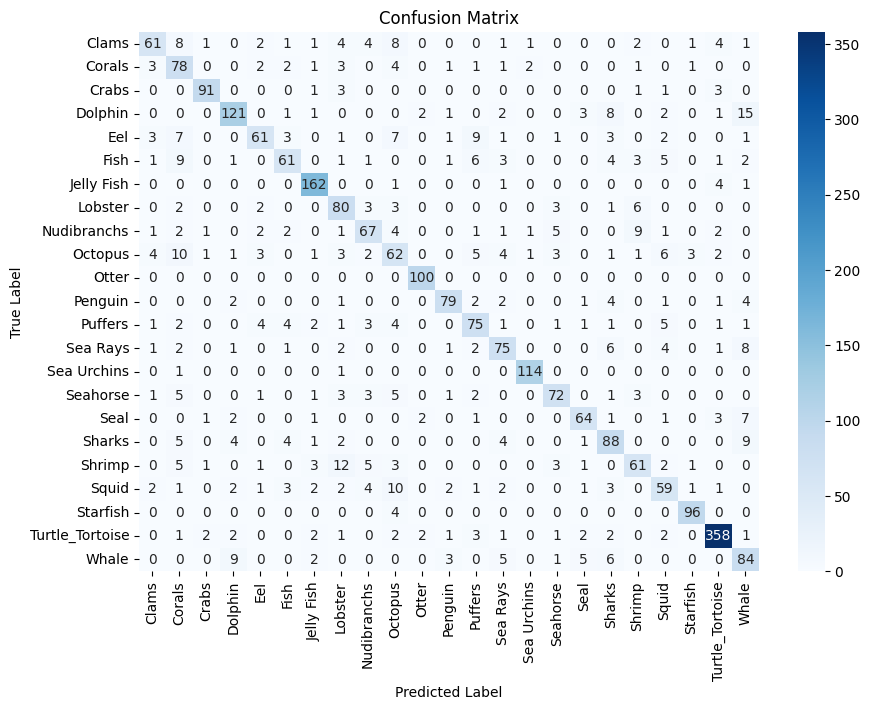

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_test = test_images.classes
cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix')
plt.show()

In [14]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

y_test = test_images.classes.tolist()

print('Accuracy Score',accuracy_score(y_test,y_pred)*100,'%')
print('Precision Macro Score ',precision_score(y_test,y_pred,average = 'macro')*100,'%')
print('Recall_Score',recall_score(y_test,y_pred, average = 'macro')*100,'%')
print('F1_Score',f1_score(y_test,y_pred, average = 'macro')*100,'%')

Accuracy Score 78.75816993464052 %
Precision Macro Score  77.23357524055179 %
Recall_Score 76.52518564050432 %
F1_Score 76.59244677275869 %


In [16]:
class_dictionary = test_images.class_indices
class_labels = {v: k for k, v in class_dictionary.items()}
class_names = list(class_labels.values())
class_labels

{0: 'Clams',
 1: 'Corals',
 2: 'Crabs',
 3: 'Dolphin',
 4: 'Eel',
 5: 'Fish',
 6: 'Jelly Fish',
 7: 'Lobster',
 8: 'Nudibranchs',
 9: 'Octopus',
 10: 'Otter',
 11: 'Penguin',
 12: 'Puffers',
 13: 'Sea Rays',
 14: 'Sea Urchins',
 15: 'Seahorse',
 16: 'Seal',
 17: 'Sharks',
 18: 'Shrimp',
 19: 'Squid',
 20: 'Starfish',
 21: 'Turtle_Tortoise',
 22: 'Whale'}

In [19]:
from keras.preprocessing.image import load_img , img_to_array

image_path = '/content/drive/MyDrive/SeaLife/val/Corals/1385561440_4e4f513e4a_o.jpg'
test_image = load_img(image_path, target_size=TARGET_SIZE)
test_image = img_to_array(test_image)  # Convert the image to an array
test_image = test_image / 255.0  # Normalize the image pixels to be between 0 and 1
test_image = np.expand_dims(test_image, axis=0)  # Add a batch dimension (required for model prediction)

prediction = loaded_model.predict(test_image)

result = np.argmax(prediction)
print(result, class_labels[result])

1/1 [==============================] - 0s 287ms/step
1 Corals
